<a href="https://colab.research.google.com/github/vartyagi/ChexRay/blob/master/PyTorch_DenseNet_t8_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip3 install torch torchvision

from __future__ import print_function
from __future__ import division

import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
#from .utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils, datasets
from skimage import io, transform
from torch.autograd import Variable

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from sklearn.metrics import multilabel_confusion_matrix

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [5]:
torch.cuda.current_device()

0

In [6]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
torch.cuda.is_available()

True

In [0]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 320

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        input_size = 320

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 16559622.77it/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
project_id = 'noble-serenity-252100'
import uuid
bucket_name = 'springboard-chexpert-capstone'
from google.colab import auth
auth.authenticate_user()

In [12]:
!gcloud config set project noble-serenity-252100

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [13]:
from __future__ import print_function
import pandas as pd
from keras.preprocessing.image import load_img
from tqdm import tqdm_notebook
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure

%matplotlib inline
import seaborn as sns

from PIL import Image
import cv2
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import label_ranking_loss
!pip install gcsfs

Using TensorFlow backend.


In [14]:

#df = pd.read_csv('gs://springboard-chexpert-capstone/frontal_images_distance_score5.csv').iloc[:,1:]
df = pd.read_csv('gs://springboard-chexpert-capstone/frontal_images_distance_score5.csv').iloc[:,1:]
df.replace(-1,0, inplace=True)
df['NewPath'] = 'gs://springboard-chexpert-capstone/' + df['NewPath']
df = df[df['DiscardFlag'] == 0]
df.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'patient', 'study', 'view', 'Count', 'UniqID',
       'NewPath', 'DistanceRotatedCropped', 'DistanceOrig',
       'SSIMRotatedCropped', 'StackValue', 'DiscardFlag', 'NoFinding_Updated'],
      dtype='object')

In [15]:
df = df[['NewPath', 'Cardiomegaly', 'Edema', 'Atelectasis', 
         'Pleural Effusion', 'Consolidation']]
df.tail()

,NewPath,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
180219,gs://springboard-chexpert-capstone/CheXpert_Pr...,0,0,0,0,1
180220,gs://springboard-chexpert-capstone/CheXpert_Pr...,0,0,0,0,1
180221,gs://springboard-chexpert-capstone/CheXpert_Pr...,0,0,0,0,0
180222,gs://springboard-chexpert-capstone/CheXpert_Pr...,0,0,0,1,0
180223,gs://springboard-chexpert-capstone/CheXpert_Pr...,0,0,0,0,0


In [16]:
dir_ = 'CheXpert-v1.0-small/'
df_valid = pd.read_csv('gs://springboard-chexpert-capstone/valid.csv')
a = df_valid['Path'].str.split("/",expand=True)
df_valid['patient']=a[2].str.replace('patient','').astype(int)
df_valid['study'] = a[3].str.replace('study','').astype(int)
df_valid['view'] = a[4].str.split('_', expand=True)[0].str.replace('view','').astype(int)
df_valid = df_valid[df_valid['Frontal/Lateral'] == 'Frontal']
df_valid['NewPath'] = df_valid['Path'].str.replace(dir_, 'gs://springboard-chexpert-capstone/')
df_valid = df_valid[['NewPath', 'Cardiomegaly', 'Edema', 'Atelectasis', 
         'Pleural Effusion', 'Consolidation']]
df_valid.tail()

,NewPath,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
229,gs://springboard-chexpert-capstone/valid/patie...,0.0,0.0,0.0,0.0,0.0
230,gs://springboard-chexpert-capstone/valid/patie...,0.0,0.0,0.0,0.0,0.0
231,gs://springboard-chexpert-capstone/valid/patie...,1.0,1.0,0.0,0.0,0.0
232,gs://springboard-chexpert-capstone/valid/patie...,0.0,0.0,0.0,0.0,0.0
233,gs://springboard-chexpert-capstone/valid/patie...,0.0,0.0,1.0,1.0,0.0


In [17]:
df.columns

Index(['NewPath', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pleural Effusion',
       'Consolidation'],
      dtype='object')

In [18]:
df.columns[1:9]

Index(['Cardiomegaly', 'Edema', 'Atelectasis', 'Pleural Effusion',
       'Consolidation'],
      dtype='object')

In [0]:
train, valid = train_test_split(df, test_size=0.05, random_state=42)

In [20]:
count_labels_df = train.iloc[:,1:9].apply(lambda x: x.value_counts())
count_labels_df

,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
0.0,149288,125664,143920,100660,158600
1.0,21077,44701,26445,69705,11765


In [21]:
count_labels_df = train.iloc[:,1:9].apply(lambda x: 100 * x.value_counts()/ x.count())
count_labels_df

,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
0.0,87.628327,73.761629,84.477445,59.084906,93.094239
1.0,12.371673,26.238371,15.522555,40.915094,6.905761


In [22]:
count_labels_df_valid = valid.iloc[:,1:9].apply(lambda x: x.value_counts())
count_labels_df_valid

,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
0.0,7839,6636,7625,5364,8329
1.0,1128,2331,1342,3603,638


In [23]:
count_labels_df_valid = valid.iloc[:,1:9].apply(lambda x: 100 * x.value_counts()/ x.count())
count_labels_df_valid

,Cardiomegaly,Edema,Atelectasis,Pleural Effusion,Consolidation
0.0,87.420542,74.004684,85.034014,59.819338,92.885023
1.0,12.579458,25.995316,14.965986,40.180662,7.114977


In [24]:
ratio = count_labels_df.iloc[0]/count_labels_df.iloc[1]

weights = torch.from_numpy(ratio.values).float()
weights

tensor([ 7.0830,  2.8112,  5.4422,  1.4441, 13.4807])

In [0]:
def smooth(x,window_len=3,window='hamming', iter_=1):
    for i in range(iter_):
        s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:
            w=eval('np.'+window+'(window_len)')

        x=np.convolve(w/w.sum(),s,mode='valid')[1:-1]
    y = x
    return np.array(y)

In [0]:
class XrayDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.xray_frame = df
        self.transform = transform
        self.y_train = np.array(self.xray_frame.iloc[:,1:9]).astype(float)
        
    def __len__(self):
        return len(self.xray_frame)

    def __getitem__(self, idx):
        img_name = self.xray_frame['NewPath'].iloc[idx]
        image = Image.open(img_name)
        #target_labels = torch.from_numpy(smooth(self.y_train[idx]))
        target_labels = torch.from_numpy(self.y_train[idx])

        if self.transform:
            image = self.transform(image)
        sample = image, target_labels
        return sample

In [0]:
class XrayDataset_test(Dataset):
    
    def __init__(self, df, transform=None):
        self.xray_frame = df
        self.transform = transform
        self.y_train = np.array(self.xray_frame.iloc[:,1:9]).astype(float)
        
    def __len__(self):
        return len(self.xray_frame)

    def __getitem__(self, idx):
        img_name = self.xray_frame['NewPath'].iloc[idx]
        image = Image.open(img_name)
        #target_labels = torch.from_numpy(smooth(self.y_train[idx]))
        target_labels = torch.from_numpy(self.y_train[idx])

        if self.transform:
            image = self.transform(image)
        sample = image, target_labels
        return sample

In [0]:
transform_train = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize([0.5247], [0.2769])
    ]) 

transform_valid = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize([0.5247], [0.2769])
    ]) 

In [0]:
data = {}
data['train'] = XrayDataset(train, transform=transform_train)
data['valid'] = XrayDataset_test(valid, transform=transform_train)
data['test'] = XrayDataset_test(df_valid, transform=transform_valid)

In [0]:
dataloaders_dict = {x: torch.utils.data.DataLoader(data[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['train', 'valid', 'test']}

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft = torch.optim.Adam(params_to_update, lr=1e-3)
optimizer_ft = torch.optim.Adam(params_to_update, lr=1e-4)



Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {'train' : [], 'valid': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9999

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            history[phase].append([]) # append empty history for current epoch
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    outputs = torch.sigmoid(outputs)
                    preds = (outputs > 0.5).float()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if batch_idx % 10 == 0:
                    history[phase][epoch].append(loss.data.cpu())
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                                   batch_idx * len(data), 
                                                                                   len(dataloaders[phase].dataset),
                                                                                   100. * batch_idx / len(dataloaders[phase]), 
                                                                                   loss.data))
            
                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                print("new model copied")
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [0]:
#criterion = torch.nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weights.float().to(device))
#criterion = torch.nn.BCEWithLogitsLoss()

In [34]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/0
----------


FileNotFoundError: ignored

In [0]:
torch.save(model_ft.state_dict(), 'densenet_model_t8_small.mdl')

In [0]:
model_ft.load_state_dict(torch.load('densenet_model_t8_small.mdl', map_location=torch.device('cpu')))
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Validation Set Metrics and Thresholding

In [0]:
from sklearn.metrics import roc_auc_score

running_corrects = 0
device = 'cpu'
model_ft = model_ft.to(device)
full_labels_valid = []
full_preds_valid = []
for batch_idx, (inputs, labels) in enumerate(dataloaders_dict['valid']):
    inputs = inputs.to(device)
    labels = labels.float()
    labels = labels.to(device)
    full_labels_valid.append(np.array(labels))
    with torch.no_grad():
        #model_ft.train()
        model_ft.eval()
        outputs = model_ft(inputs)
        #loss1 = criterion(outputs, labels)
        outputs = torch.sigmoid(outputs)
        full_preds_valid.append(np.array(outputs))
    #print('Batch #: ', batch_idx, '\nTrue:\n', np.array(labels.cpu()), '\nPredicted:\n', np.array(preds.cpu()))

full_labels_valid = np.concatenate(full_labels_valid)
full_preds_valid = np.concatenate(full_preds_valid)

labels_list = ['Cardiomegaly', 'Edema', 'Atelectasis', 'Pleural Effusion', 'Consolidation']

auc_scores = {labels_list[i] : roc_auc_score(full_labels_valid[:,i],full_preds_valid[:,i]) for i in range(len(labels_list))}
print(auc_scores)

{'Cardiomegaly': 0.7977053331223294, 'Edema': 0.7717687424503328, 'Atelectasis': 0.585760976570191, 'Pleural Effusion': 0.8063574086656237, 'Consolidation': 0.6415063323708511}


In [0]:
from sklearn.metrics import roc_curve
fpr = dict()
tpr = dict()
thr = dict()
for i in range(len(labels_list)):
    fpr[i], tpr[i], thr[i] = roc_curve(full_labels_valid[:,i],full_preds_valid[:,i])

<Figure size 432x288 with 0 Axes>

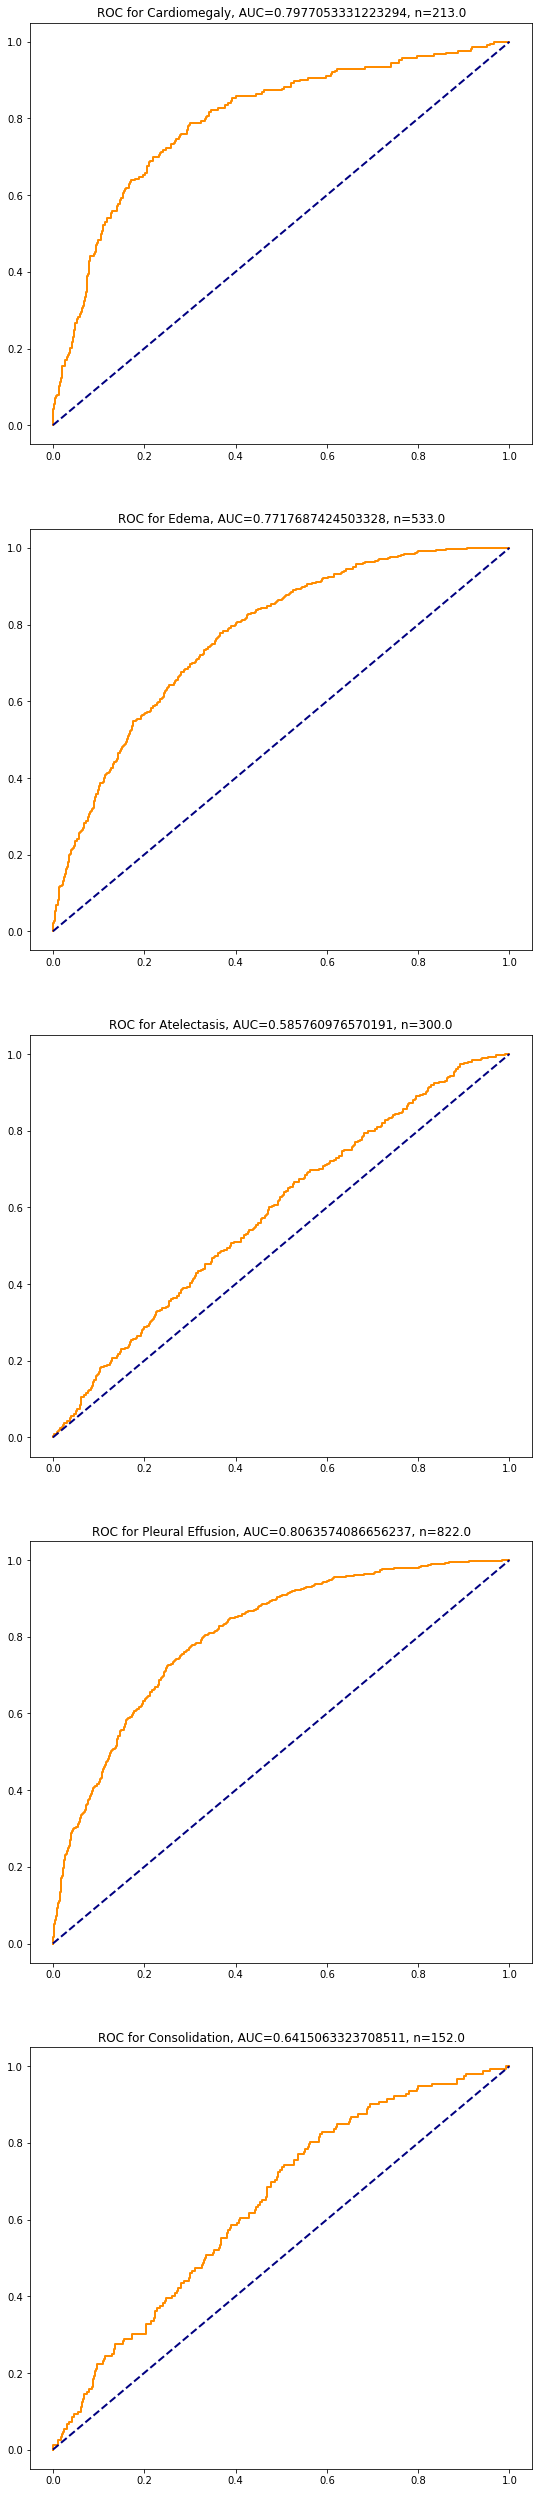

In [0]:
plt.figure()
fig, axs = plt.subplots(5, 1, figsize=(9,45)) 
lw = 2
counts = np.sum(full_labels_valid, axis=0)
for i in range(len(labels_list)):
    axs[i].plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve')
    axs[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axs[i].set_title('ROC for {}, AUC={}, n={}'.format(labels_list[i], auc_scores[labels_list[i]], counts[i]))


In [0]:
# find threshold for each class to maximize F1

thresh = np.arange(0,1,0.01)
max_class_accuracy = np.zeros(5)
best_thresholds = np.zeros(5)
for thr in thresh:
    mcm = multilabel_confusion_matrix(full_labels_valid, (full_preds_valid > thr).astype(float))
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    recall = tp / (tp + fn) 
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    threat = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    for class_num in range(mcm.shape[0]):
        if f1[class_num] > max_class_accuracy[class_num]:
            max_class_accuracy[class_num] = f1[class_num]
            best_thresholds[class_num] = thr

print('Best Validation Thresholds: ', best_thresholds)

mcm = multilabel_confusion_matrix(full_labels_valid, (full_preds_valid > best_thresholds).astype(float))
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
recall = tp / (tp + fn) 
precision = tp / (tp + fp)
specificity = tn / (tn + fp)
fallout = fp / (fp + tn)
miss = fn / (fn + tp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * precision * recall / (precision + recall)
print('Validation Recall:', recall, '\n',
#      'Precision: ', precision, '\n',
#     'Specificity:', specificity, '\n',
#     'Fallout:', fallout, '\n',
#     'Miss: ', miss, '\n',
#     'Accuracy: ', accuracy, '\n',
     'Validation F1: ', f1)

Best Validation Thresholds:  [0.67 0.57 0.44 0.48 0.54]
Validation Recall: [0.5399061  0.77861163 0.64333333 0.82846715 0.73026316] 
 Validation F1:  [0.42671614 0.55667337 0.28445099 0.70606532 0.18829517]


/home/varun/.conda/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/varun/.conda/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


## Test Set Metrics

In [0]:
running_corrects = 0
device = 'cpu'
model_ft = model_ft.to(device)
full_labels_test = []
full_preds_test = []
for batch_idx, (inputs, labels) in enumerate(dataloaders_dict['test']):
    inputs = inputs.to(device)
    labels = labels.float()
    labels = labels.to(device)
    full_labels_test.append(np.array(labels))
    with torch.no_grad():
        #model_ft.train()
        model_ft.eval()
        outputs = model_ft(inputs)
        #loss1 = criterion(outputs, labels)
        outputs = torch.sigmoid(outputs)
        full_preds_test.append(np.array(outputs))
    #print('Batch #: ', batch_idx, '\nTrue:\n', np.array(labels.cpu()), '\nPredicted:\n', np.array(preds.cpu()))

full_labels_test = np.concatenate(full_labels_test)
full_preds_test = np.concatenate(full_preds_test)


auc_scores_test = {labels_list[i] : roc_auc_score(full_labels_test[:,i],full_preds_test[:,i]) 
                   for i in range(len(labels_list))
                  }
print(auc_scores_test)

{'Cardiomegaly': 0.8202985739750446, 'Edema': 0.8171130952380953, 'Atelectasis': 0.7625196850393701, 'Pleural Effusion': 0.8463541666666666, 'Consolidation': 0.8779411764705882}


<Figure size 432x288 with 0 Axes>

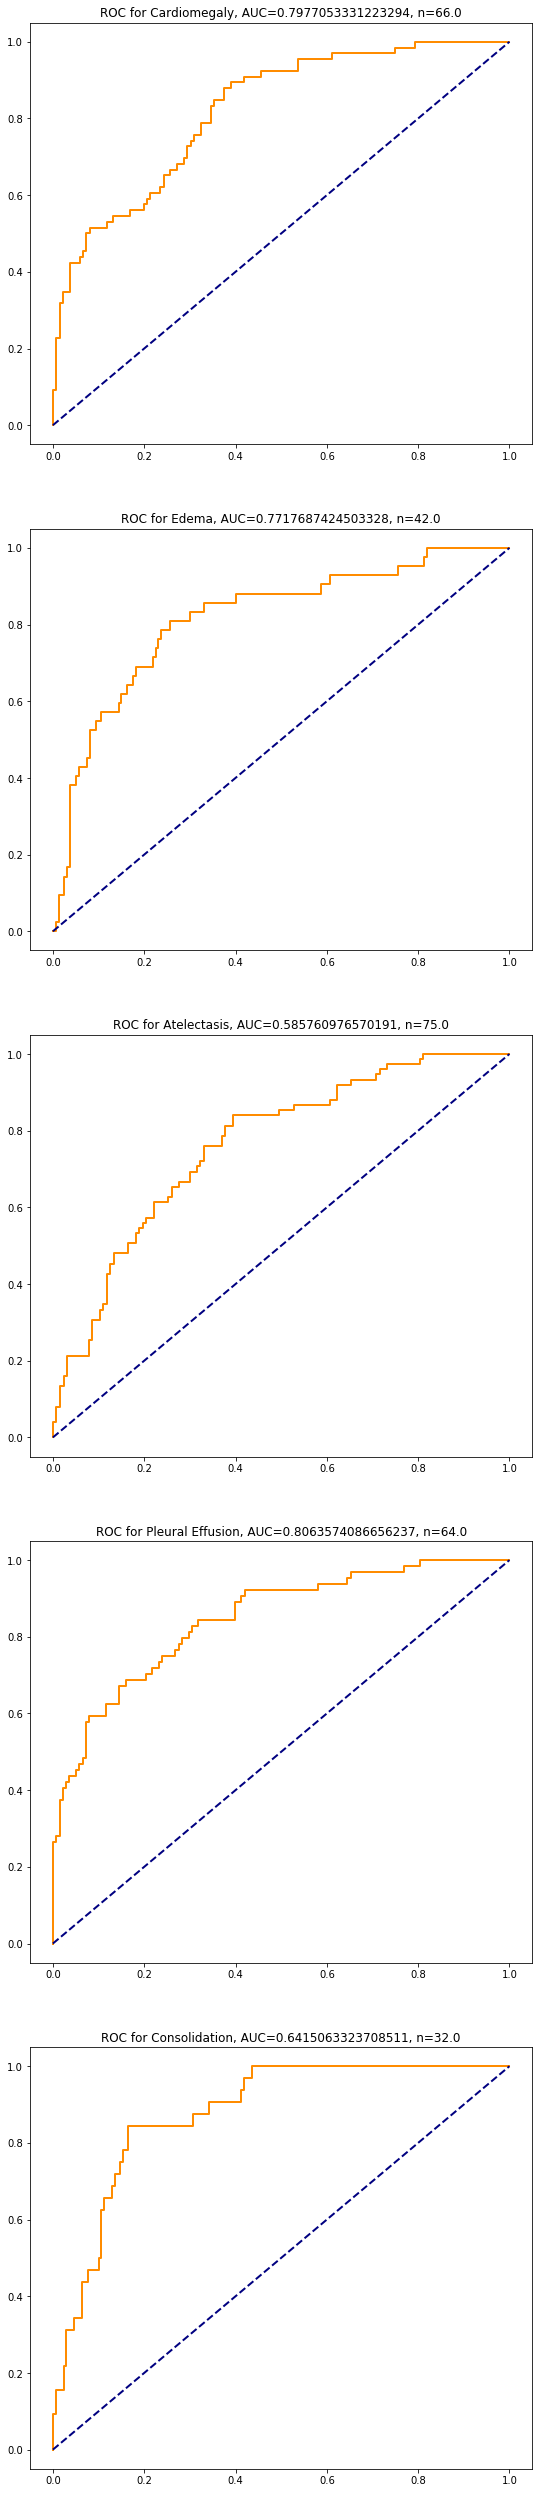

In [0]:
fpr = dict()
tpr = dict()
thr = dict()
for i in range(len(labels_list)):
    fpr[i], tpr[i], thr[i] = roc_curve(full_labels_test[:,i],full_preds_test[:,i])

plt.figure()
fig, axs = plt.subplots(5, 1, figsize=(9,45)) 
lw = 2
counts = np.sum(full_labels_test, axis=0)
for i in range(len(labels_list)):
    axs[i].plot(fpr[i], tpr[i], color='darkorange',
         lw=lw, label='ROC curve')
    axs[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axs[i].set_title('ROC for {}, AUC={}, n={}'.format(labels_list[i], auc_scores[labels_list[i]], counts[i]))


## Applying validation set thresholds to test set and calculating F1 and Recall

In [0]:
mcm = multilabel_confusion_matrix(full_labels_test, (full_preds_test > best_thresholds).astype(float))
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
recall = tp / (tp + fn) 
precision = tp / (tp + fp)
specificity = tn / (tn + fp)
fallout = fp / (fp + tn)
miss = fn / (fn + tp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * precision * recall / (precision + recall)
print('Test Set Recall:', recall, '\n',
#      'Precision: ', precision, '\n',
#     'Specificity:', specificity, '\n',
#     'Fallout:', fallout, '\n',
#     'Miss: ', miss, '\n',
#     'Accuracy: ', accuracy, '\n',
     'Test Set F1: ', f1)

Test Set Recall: [0.16666667 0.80952381 0.66666667 0.71875    0.875     ] 
 Test Set F1:  [0.28205128 0.56666667 0.62111801 0.65714286 0.49122807]


## Looking at whether thresholds calculated on test set perform better for the test set

In [0]:
thresh = np.arange(0,1,0.01)
max_class_accuracy = np.zeros(5)
best_thresholds_test = np.zeros(5)
for thr in thresh:
    mcm = multilabel_confusion_matrix(full_labels_test, (full_preds_test > thr).astype(float))
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    recall = tp / (tp + fn) 
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    threat = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    for class_num in range(mcm.shape[0]):
        if f1[class_num] > max_class_accuracy[class_num]:
            max_class_accuracy[class_num] = f1[class_num]
            best_thresholds_test[class_num] = thr
            
mcm = multilabel_confusion_matrix(full_labels_test, (full_preds_test > best_thresholds_test).astype(float))
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
recall = tp / (tp + fn) 
precision = tp / (tp + fp)
specificity = tn / (tn + fp)
fallout = fp / (fp + tn)
miss = fn / (fn + tp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = 2 * precision * recall / (precision + recall)
print('Test Set Recall With Different Thresholds:', recall, '\n',
#      'Precision: ', precision, '\n',
#     'Specificity:', specificity, '\n',
#     'Fallout:', fallout, '\n',
#     'Miss: ', miss, '\n',
#     'Accuracy: ', accuracy, '\n',
     'Test Set F1 With Different Thresholds: ', f1)

Test Set Recall With Different Thresholds: [0.87878788 0.78571429 0.82666667 0.6875     0.84375   ] 
 Test Set F1 With Different Thresholds:  [0.65536723 0.57391304 0.6631016  0.67175573 0.62068966]


/home/varun/.conda/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
